In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
# from mpl_toolkits.mplot3d import Axes3D

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data
from torchvision import datasets, transforms as T

import random, os, pathlib, time
from tqdm import tqdm
# from sklearn import datasets

In [2]:
# device = torch.device("cuda:0")
device = torch.device("cpu")

In [3]:
from tqdm import tqdm
import os, time, sys
import json

In [4]:
import dtnnlib as dtnn

In [5]:
mnist_transform = T.Compose([
    T.ToTensor(),
    T.Normalize(
        mean=[0.5,],
        std=[0.5,],
    ),
])

# train_dataset = datasets.FashionMNIST(root="../../../_Datasets/", train=True, download=True, transform=mnist_transform)
# test_dataset = datasets.FashionMNIST(root="../../../_Datasets/", train=False, download=True, transform=mnist_transform)
train_dataset = datasets.MNIST(root="../../../_Datasets/", train=True, download=True, transform=mnist_transform)
test_dataset = datasets.MNIST(root="../../../_Datasets/", train=False, download=True, transform=mnist_transform)

In [6]:
batch_size = 50
train_loader = data.DataLoader(dataset=train_dataset, num_workers=4, batch_size=batch_size, shuffle=True)
test_loader = data.DataLoader(dataset=test_dataset, num_workers=4, batch_size=batch_size, shuffle=False)

In [7]:
for xx, yy in train_loader:
    xx, yy = xx.to(device), yy.to(device)
    print(xx.shape, yy.shape)
    break

torch.Size([50, 1, 28, 28]) torch.Size([50])


## 1 Layer epsilon Softmax MLP

In [8]:
"""
Idea: to not use epsilon softmax during training, but only when checking uncertainity.
Train -> do not store epsilon.
Eval -> return without epsilon, but also store epsilon..


"""

'\nIdea: to not use epsilon softmax during training, but only when checking uncertainity.\nTrain -> do not store epsilon.\nEval -> return without epsilon, but also store epsilon..\n\n\n'

In [9]:
class DistanceTransform_Epsilon_eval(dtnn.DistanceTransformBase):
    
    def __init__(self, input_dim, num_centers, p=2, bias=False, epsilon=0.1):
        super().__init__(input_dim, num_centers, p=2)
        
        nc = num_centers
        self.scaler = nn.Parameter(torch.log(torch.ones(1, 1)*1))
        self.epsilon = epsilon
        
    def forward(self, x, calculate_epsilon=False):
        dists = super().forward(x)
        
        if calculate_epsilon:
            dists = torch.cat([dists, torch.ones(len(x), 1, dtype=x.dtype)*self.epsilon], dim=1)
        
        ### normalize similar to UMAP
        dists = dists/torch.sqrt(dists.var(dim=1, keepdim=True)+1e-9)
#         dists = dists/(torch.norm(dists, dim=1, keepdim=True)+1e-9)

        ## scale the dists
        dists = -dists*torch.exp(self.scaler)
    
        return dists

In [10]:
class DTeSM(DistanceTransform_Epsilon_eval):
    
    def __init__(self, input_dim, output_dim, epsilon=1.0):
        super().__init__(input_dim, output_dim, bias=True, epsilon=epsilon)
        
        self.scale_shift = dtnn.ScaleShift(-1, scaler_init=3, shifter_init=0, scaler_const=True, shifter_const=True)
        self.softmax = nn.Softmax(dim=-1)
        self.temp_activ = None
        pass
        
    def forward(self, x, calculate_epsilon=False):
        if calculate_epsilon:
            with torch.no_grad():
                xo = super().forward(x, True)
                xo = self.scale_shift(xo)
                xo = self.softmax(xo)
                self.temp_activ = xo
        
        xo = super().forward(x)
        xo = self.scale_shift(xo)
        xo = self.softmax(xo)
        return xo

In [11]:
# DTeSM(2, 5, 0.1)(torch.randn(1, 2)).shape
# DTeSM(2, 5, 0.1)(torch.randn(1, 2), calculate_epsilon=True).shape

In [12]:
class LocalMLP_epsilonsoftmax_eval(nn.Module):
    
    def __init__(self, input_dim, hidden_dim0, hidden_dim1, output_dim):
        super().__init__()
        
        self.layer0 = DTeSM(input_dim, hidden_dim0, epsilon=10)
        self.layer1 = DTeSM(hidden_dim0, hidden_dim1, epsilon=5)
        
        self.layer2 = nn.Linear(hidden_dim1, output_dim)
        pass
        
    def forward(self, x, calculate_epsilon = False):
        xo = self.layer0(x, calculate_epsilon)
        xo = self.layer1(xo, calculate_epsilon)
        xo = self.layer2(xo)
        return xo

In [13]:
h0 = 200
h1 = 60
model = LocalMLP_epsilonsoftmax_eval(784, h0, h1, 10)

In [14]:
model.to(device)

LocalMLP_epsilonsoftmax_eval(
  (layer0): DTeSM(
    (scale_shift): ScaleShift()
    (softmax): Softmax(dim=-1)
  )
  (layer1): DTeSM(
    (scale_shift): ScaleShift()
    (softmax): Softmax(dim=-1)
  )
  (layer2): Linear(in_features=60, out_features=10, bias=True)
)

In [15]:
model(xx.reshape(-1, 28*28)).shape

torch.Size([50, 10])

In [16]:
def get_random_training_samples(N):
    new_center = []
    new_labels = []
    count = 0
    for i, (xx, yy) in enumerate(train_loader):
        xx = xx.reshape(xx.shape[0], -1)
        if count+xx.shape[0] < N:
            new_center.append(xx)
            new_labels.append(yy)
            count += xx.shape[0]
        elif count >= N:
            break
        else:
            new_center.append(xx[:N-count])
            new_labels.append(yy[:N-count])
            count = N
            break

    new_center = torch.cat(new_center, dim=0)
    new_labels = torch.cat(new_labels, dim=0)
    
    weights = torch.zeros(len(new_labels), 10)
    for i in range(len(new_labels)):
        weights[i, new_labels[i]] = 1.
    
    return new_center.to(device), weights.to(device)

In [17]:
get_random_training_samples(2)

(tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]]),
 tensor([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]]))

In [18]:
c0, _ = get_random_training_samples(h0)

In [19]:
## first layer
model.layer0.centers.data = c0.to(model.layer0.centers.device)

In [20]:
c1, v1 = get_random_training_samples(h1)

In [21]:
## second layer
model.layer1.centers.data = model.layer0(c1.to(device))
model.layer2.weight.data = v1.t().to(device)

In [22]:
# def train(epoch, model, optimizer):
#     model.train()
#     train_loss = 0
#     correct = 0
#     total = 0
#     for batch_idx, (inputs, targets) in enumerate(tqdm(train_loader)):
#         inputs, targets = inputs.to(device).view(-1, 28*28), targets.to(device)
        
#         ### Train with random image and "10" as class
# #         inputs = torch.cat([inputs, torch.rand(batch_size//10, 28*28, dtype=inputs.dtype).to(device)*2-1], dim=0)
# #         targets = torch.cat([targets, torch.ones(batch_size//10, dtype=targets.dtype).to(device)*10], dim=0)
        
#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = criterion(outputs, targets)
#         loss.backward()
#         optimizer.step()

#         train_loss += loss.item()
#         _, predicted = outputs.max(1)
#         total += targets.size(0)
#         correct += predicted.eq(targets).sum().item()
#     print(f"[Train] {epoch} Loss: {train_loss/(batch_idx+1):.3f} | Acc: {100.*correct/total:.3f} {correct}/{total}")
#     return

In [23]:
best_acc = -1
def test(epoch, model):
    global best_acc
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
#         for batch_idx, (inputs, targets) in enumerate(tqdm(test_loader)):
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device).view(-1, 28*28), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
    print(f"[Test] {epoch} Loss: {test_loss/(batch_idx+1):.3f} | Acc: {100.*correct/total:.3f} {correct}/{total}")
    
    acc = 100.*correct/total
    return acc

In [24]:
model.eval()

LocalMLP_epsilonsoftmax_eval(
  (layer0): DTeSM(
    (scale_shift): ScaleShift()
    (softmax): Softmax(dim=-1)
  )
  (layer1): DTeSM(
    (scale_shift): ScaleShift()
    (softmax): Softmax(dim=-1)
  )
  (layer2): Linear(in_features=60, out_features=10, bias=True)
)

In [25]:
criterion = nn.CrossEntropyLoss()

In [26]:
test_acc = test(0, model)
test_acc

[Test] 0 Loss: 2.102 | Acc: 40.280 4028/10000


40.28

### Model Training - evaluation

In [27]:
learning_rate = 0.01
# EPOCHS = 10
EPOCHS = 0

In [28]:
p1, p2 = [], []
for p in model.named_parameters():
    if p[0].endswith(".centers"):
        p1.append(p[1])
    else:
        p2.append(p[1])

params = [
    {"params": p1, "lr": learning_rate*0.03}, ## default - to change little from data point
#     {"params": p1},
    {"params": p2},
]

In [29]:
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

optimizer = torch.optim.Adam(params, lr=learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

best_acc = -1
for epoch in range(EPOCHS):
    train(epoch, model, optimizer)
    test(epoch, model)
    scheduler.step()
    
"""
Note: It trains to about 95% on MNIST
"""
print()

## Multilayer Noisy Selection (Type 1)

In [30]:
"""
TYPE 1: DT>eSM>DT>eSM>V
Type 2:  /DT>eSM>S\
        X---------+\>eSM>V
"""
print()

## Add new centers to the model

In [31]:
"""
1) initialize the models with data0, data1
2) to add neurons to dt0, calculate respective activation with data1 and initialize the dt1
    - for dt1, input dim increase and output dim stay same ;
    - the hidden activation changes slightly..
    
3) to add neurons to dt1, same as 2 layer addition..
"""
print()

In [32]:
h0 = 200
h1 = 60
model = LocalMLP_epsilonsoftmax_eval(784, h0, h1, 10).to(device)

In [33]:
N_search0 = 30
N_search1 = 10

### Initialization

In [34]:
c0, _ = get_random_training_samples(h0)

In [35]:
model.layer0.centers.data = c0.to(model.layer0.centers.device)

In [36]:
c1, v1 = get_random_training_samples(h1)

In [37]:
model.layer1.centers.data = model.layer0(c1.to(device))
model.layer2.weight.data = v1.t().to(device)

In [38]:
test_acc = test(0, model)

[Test] 0 Loss: 2.141 | Acc: 36.310 3631/10000


In [39]:
## Initialize to take the new_activation info of centers in layer 1..
### The activation distribution changes due to entangled(softmax and normalization in DTeSM)
def add_neurons_to_layer0(model, centers0, old_centers1): ## the parameters should not change
    
    ########## LAYER 0 ############
    c0 = torch.cat((model.layer0.centers.data, centers0), dim=0)
    
#     s0 = torch.cat([model.layer0.bias.data, torch.ones(1, len(centers0))*0], dim=1)

    model.layer0.centers.data = c0
#     model.layer0.bias.data = s0

#     v = torch.cat((model.layer1.weight.data, values.t()), dim=1)
#     model.layer1.weight.data = v

    ########## LAYER 1 ############
#     c1 = torch.cat((model.layer1.centers.data, model.layer0(centers1)), dim=0) ## initial: add center activation1
#     all_centers = torch.cat([old_centers1, centers1], dim=0)
#     c1 = model.layer0(all_centers) ## initial: add center activation1
    
    model.layer1.centers.data = model.layer0(old_centers1)
    pass

In [40]:
def add_neurons_to_layer1(model, centers1, values1, old_centers1):
    all_centers = torch.cat([old_centers1, centers1], dim=0)
    
#     c1 = torch.cat((model.layer1.centers.data, model.layer0(centers1)), dim=0)
    c1 = model.layer0(all_centers)
#     s1 = torch.cat([model.layer1.bias.data, torch.ones(1, len(centers1))*0], dim=1)
    v = torch.cat((model.layer2.weight.data, values1.t()), dim=1)

    model.layer1.centers.data = c1
#     model.layer1.bias.data = s1
    model.layer2.weight.data = v
    
    return all_centers

In [41]:
model.layer0.centers.data.shape, model.layer1.centers.data.shape, model.layer2.weight.data.shape

(torch.Size([200, 784]), torch.Size([60, 200]), torch.Size([10, 60]))

In [42]:
_c0 = get_random_training_samples(N_search0)[0]
add_neurons_to_layer0(model, _c0, c1)

In [43]:
model.layer0.centers.data.shape, model.layer1.centers.data.shape

(torch.Size([230, 784]), torch.Size([60, 230]))

In [44]:
test_acc2 = test(0, model)
test_acc2, test_acc ### ?? why does adding new centers to layer0 reduce the accuracy ??

[Test] 0 Loss: 2.160 | Acc: 31.630 3163/10000


(31.63, 36.31)

In [45]:
### Add neurons to second layer
_c1, _v1 = get_random_training_samples(N_search1)
c1 = add_neurons_to_layer1(model, _c1, _v1, c1)

In [46]:
model.layer1.centers.data.shape, model.layer2.weight.data.shape

(torch.Size([70, 230]), torch.Size([10, 70]))

In [47]:
test_acc3 = test(0, model)
test_acc3, test_acc2, test_acc

[Test] 0 Loss: 2.143 | Acc: 33.090 3309/10000


(33.09, 31.63, 36.31)

In [48]:
# asdsadsd

## Calculate Neuron Significance

In [49]:
layer_keys = [model.layer0, model.layer1]
outputs = {k.softmax:None for k in layer_keys}
gradients = {k.softmax:None for k in layer_keys}

def capture_outputs(module, inp, out):
    global outputs
    outputs[module] = out.data.cpu()

def capture_gradients(module, gradi, grado):
    global gradients
    gradients[module] = grado[0].data.cpu()
        
forw_hooks = [k.softmax.register_forward_hook(capture_outputs) for k in layer_keys]
back_hooks = [k.softmax.register_backward_hook(capture_gradients) for k in layer_keys]

def remove_hook():
    for hook in forw_hooks+back_hooks:
        hook.remove()
    pass

In [50]:
significance = {k.softmax:torch.zeros(k.centers.shape[0]) for k in layer_keys}
significance

{Softmax(dim=-1): tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0

In [51]:
for xx, yy in train_loader:
    xx, yy = xx.to(device).view(-1, 28*28), yy.to(device)
    print(xx.shape, yy.shape)
    break

torch.Size([50, 784]) torch.Size([50])


In [52]:
yout = model(xx)
yout.shape

torch.Size([50, 10])

In [53]:
for n, p in model.named_parameters():
    print(n,"\t" ,p.shape)

layer0.centers 	 torch.Size([230, 784])
layer0.scaler 	 torch.Size([1, 1])
layer1.centers 	 torch.Size([70, 230])
layer1.scaler 	 torch.Size([1, 1])
layer2.weight 	 torch.Size([10, 70])
layer2.bias 	 torch.Size([10])


In [54]:
def none_grad():
    for p in model.parameters():
        p.grad = None

In [55]:
none_grad()
yout.register_hook(lambda grad: grad/torch.norm(grad, dim=1, keepdim=True))

# grad = torch.randn_like(yout)
# ### grad = grad/torch.norm(grad, dim=1, keepdim=True)
# yout.backward(gradient=grad, retain_graph=False)

criterion(yout, yy).backward()

In [56]:
remove_hook()

In [57]:
outputs

{Softmax(dim=-1): tensor([[5.5955e-03, 2.6959e-05, 1.4790e-05,  ..., 2.4560e-06, 1.0225e-03,
          9.2740e-05],
         [1.2230e-06, 1.4006e-01, 2.3846e-06,  ..., 8.8221e-08, 1.0266e-04,
          3.8485e-05],
         [3.8386e-06, 9.2652e-03, 2.5326e-06,  ..., 2.2203e-06, 3.4260e-04,
          6.5213e-05],
         ...,
         [3.2783e-05, 6.4050e-04, 6.0128e-06,  ..., 2.9462e-07, 7.6330e-04,
          1.0532e-04],
         [6.7561e-05, 2.1577e-06, 1.7320e-04,  ..., 1.4732e-07, 1.5507e-06,
          9.3436e-08],
         [6.4740e-06, 1.5893e-03, 3.2063e-06,  ..., 3.6412e-06, 3.0054e-04,
          6.6040e-05]]),
 Softmax(dim=-1): tensor([[4.8367e-06, 1.3909e-02, 5.4262e-06,  ..., 3.4233e-03, 2.6036e-03,
          5.3273e-04],
         [1.8988e-05, 5.6326e-02, 2.1200e-05,  ..., 1.1724e-02, 1.2167e-02,
          2.2377e-03],
         [2.1262e-05, 8.5921e-02, 2.3758e-05,  ..., 1.5280e-02, 3.3241e-02,
          2.5969e-03],
         ...,
         [1.4054e-05, 1.7406e-01, 1.5574e-05,

In [58]:
gradients

{Softmax(dim=-1): tensor([[-2.1100e-01,  2.2212e-02,  1.7308e-03,  ...,  1.1795e-05,
           3.1190e-02,  3.8565e-03],
         [ 1.2575e-02, -2.2375e-01,  1.2142e-03,  ...,  1.1818e-05,
           8.6896e-03,  1.0803e-03],
         [ 3.6899e-03,  3.4449e-02,  1.8759e-03,  ...,  5.2858e-06,
           3.0681e-02,  3.3892e-03],
         ...,
         [-2.2441e-02, -1.2346e-02,  6.3127e-04,  ...,  1.9360e-05,
           2.6107e-02,  4.6250e-03],
         [-9.2462e-05,  5.9037e-05, -8.5532e-07,  ..., -3.7203e-08,
           4.8198e-05,  5.6157e-06],
         [ 3.7770e-03,  1.0704e-02,  1.1123e-03,  ...,  2.0596e-06,
           1.1598e-02,  1.2042e-03]]),
 Softmax(dim=-1): tensor([[0.1006, 0.1006, 0.1060,  ..., 0.1107, 0.1060, 0.1107],
         [0.1044, 0.1044, 0.1017,  ..., 0.1075, 0.1017, 0.1075],
         [0.1144, 0.1144, 0.1078,  ..., 0.1085, 0.1078, 0.1085],
         ...,
         [0.1231, 0.1231, 0.0996,  ..., 0.1058, 0.0996, 0.1058],
         [0.0995, 0.0995, 0.1069,  ..., 0.1113

In [59]:
with torch.no_grad():
    for k in layer_keys:
        lk = k.softmax
#         print(outputs[lk])
#         print(gradients[lk])
#         print(significance[lk])
        significance[lk] += torch.sum((outputs[lk]*gradients[lk])**2, dim=0)
significance

{Softmax(dim=-1): tensor([1.9249e-02, 1.0787e-03, 1.1615e-11, 9.0257e-13, 6.5465e-05, 4.0700e-05,
         3.9585e-08, 2.5843e-05, 1.3649e-08, 4.5141e-07, 1.7529e-02, 5.9360e-05,
         6.9902e-05, 3.1605e-06, 1.1921e-05, 2.8067e-03, 8.4503e-07, 2.9518e-03,
         2.6002e-09, 4.0400e-02, 1.6231e-04, 4.2388e-06, 2.3011e-08, 1.0238e-02,
         5.1121e-09, 5.2800e+00, 1.6031e-03, 2.3117e-04, 1.1233e-10, 6.9011e-05,
         4.7227e-04, 1.8110e-05, 1.1922e-05, 3.7548e-05, 2.1607e-08, 3.5626e-03,
         2.3790e+00, 1.0455e-04, 5.4865e-08, 1.8841e-02, 9.5044e-08, 2.0742e-04,
         1.1890e-04, 2.1775e-09, 5.2436e-05, 1.0845e-05, 7.7015e-08, 1.7216e-05,
         1.1164e-02, 1.7985e-06, 3.9749e-07, 1.1654e-08, 1.4592e-05, 5.0684e-01,
         3.6223e-04, 3.2234e-04, 1.2663e-08, 1.3185e-12, 1.2040e-09, 2.8953e-02,
         4.6576e-06, 1.2930e-03, 3.8716e-04, 1.7419e-11, 7.4305e-05, 1.3809e+00,
         1.0175e-05, 2.4941e-07, 6.6955e-07, 2.0041e-03, 6.5995e-09, 3.1922e-05,
         5.

In [60]:
h0

200

In [61]:
sig = significance[layer_keys[0].softmax]

In [62]:
# torch.topk(sig, k=h0, sorted=True, largest=True)[0]

In [63]:
topk_idx = torch.topk(sig, k=h0, sorted=True)[1]
topk_idx

tensor([216,  25,  36,  65,  53, 114, 167, 104, 217, 161, 178, 176, 175,  19,
        160, 135, 110,  59, 206, 123,   0,  39,  10,  48,  23, 119, 205,  35,
        113, 185,  17,  15, 215,  93,  69, 171,  26,  90, 145, 116,  61, 131,
        101,   1, 183, 115, 193, 152,  74, 105, 223, 192, 100, 159, 122, 165,
         30,  62,  54, 228, 169,  55, 173, 153, 109,  27, 180, 124, 111, 120,
         41, 197, 158, 108,  20, 188, 137, 170,  42,  95,  37,  77, 164,  64,
        191,  12,  29,   4, 210,  11,  44, 187,   5,  33,  81,  71,  82,   7,
        211,  76, 121, 181,  31, 143,  47,  52,  32,  14,  45, 201,  92,  66,
        202, 213,  75,  87,  60,  21, 157,  13, 141, 132, 166, 144, 172, 125,
        133,  49, 151,  79,  86,  88, 149, 219,  89, 126,  96, 203, 212, 218,
         16,  68, 134, 148,  72, 220, 118,   9, 103, 177,  50, 112, 184, 199,
        227, 106, 189,  67, 222, 146, 196, 139, 198, 190, 168,  40, 209,  46,
         94, 225, 214,  38, 163, 195,   6, 147,  73,  22,  34,  

In [64]:
def remove_neurons_from_layer1(model, importance, num_prune, old_centers1):
    N = model.layer1.centers.shape[0]
    topk_idx = torch.topk(importance, k=N-num_prune, largest=True)[1]
    
    c = model.layer1.centers.data[topk_idx]
    v = model.layer2.weight.data[:,topk_idx]
#     s = model.layer1.bias.data[:,topk_idx]
    model.layer1.centers.data = c
    model.layer2.weight.data = v
#     model.layer1.bias.data = s
    
    return old_centers1[topk_idx]

In [65]:
def remove_neurons_from_layer0(model, importance, num_prune, old_centers1):
    N = model.layer0.centers.shape[0]
    topk_idx = torch.topk(importance, k=N-num_prune, largest=True)[1]
    
    c = model.layer0.centers.data[topk_idx]
#     s = model.layer0.bias.data[:,topk_idx]
    model.layer0.centers.data = c
#     model.layer0.bias.data = s
    
    model.layer1.centers.data = model.layer0(old_centers1)
    pass

In [66]:
# asdasd

In [67]:
c1 = remove_neurons_from_layer1(model, significance[layer_keys[1].softmax], N_search1, c1)

In [68]:
c1.shape

torch.Size([60, 784])

In [69]:
model.layer0.centers.data.shape, model.layer1.centers.data.shape, model.layer2.weight.data.shape

(torch.Size([230, 784]), torch.Size([60, 230]), torch.Size([10, 60]))

In [70]:
test_acc4 = test(0, model)

test_acc4, test_acc3, test_acc2, test_acc

[Test] 0 Loss: 2.140 | Acc: 32.430 3243/10000


(32.43, 33.09, 31.63, 36.31)

In [71]:
remove_neurons_from_layer0(model, significance[layer_keys[0].softmax], N_search0, c1)

In [72]:
model.layer0.centers.data.shape, model.layer1.centers.data.shape, model.layer2.weight.data.shape

(torch.Size([200, 784]), torch.Size([60, 200]), torch.Size([10, 60]))

In [73]:
test_acc5 = test(0, model)
test_acc5, test_acc4, test_acc3, test_acc2, test_acc

[Test] 0 Loss: 2.130 | Acc: 32.390 3239/10000


(32.39, 32.43, 33.09, 31.63, 36.31)

In [74]:
asdasd

NameError: name 'asdasd' is not defined

## Do this in Loop

In [75]:
_c0 = get_random_training_samples(N_search0)[0]
add_neurons_to_layer0(model, _c0, c1)

_c1, _v1 = get_random_training_samples(N_search1)
c1 = add_neurons_to_layer1(model, _c1, _v1, c1)

In [76]:
significance = {k.softmax:torch.zeros(k.centers.shape[0]) for k in layer_keys}

forw_hooks = [k.softmax.register_forward_hook(capture_outputs) for k in layer_keys]
back_hooks = [k.softmax.register_backward_hook(capture_gradients) for k in layer_keys]

In [77]:
# optim = torch.optim.Adam(model.parameters())

In [78]:
for xx, yy in train_loader:
    xx = xx.to(device).view(-1, 28*28)
    yout = model(xx)
    
    none_grad()
#     yout.register_hook(lambda grad: grad/torch.norm(grad, dim=1, keepdim=True))
    
#     grad = torch.randn_like(yout)
#     ### grad = grad/torch.norm(grad, dim=1, keepdim=True)
#     yout.backward(gradient=grad)
    
    criterion(yout, yy).backward()
    
    with torch.no_grad():
        for k in layer_keys:
            lk = k.softmax
            significance[lk] += torch.sum((outputs[lk]*gradients[lk])**2, dim=0)
    pass

In [79]:
remove_hook()

In [80]:
c1 = remove_neurons_from_layer1(model, significance[layer_keys[1].softmax], N_search1, c1) ## anything can be done first
remove_neurons_from_layer0(model, significance[layer_keys[0].softmax], N_search0, c1)

In [81]:
test(0, model)

[Test] 0 Loss: 2.131 | Acc: 34.430 3443/10000


34.43

In [ ]:
asdasd  ### ^^ expected test_acc2 > test_acc3 > test_acc

## Optimize for multiple steps

In [82]:
h0 = 100
h1 = 100
N_search0 = 30
N_search1 = 30
model = LocalMLP_epsilonsoftmax_eval(784, h0, h1, 10).to(device)

### Initialization
c0, _ = get_random_training_samples(h0)
model.layer0.centers.data = c0.to(model.layer0.centers.device)

c1, v1 = get_random_training_samples(h1)
model.layer1.centers.data = model.layer0(c1.to(device))
model.layer2.weight.data = v1.t().to(device)

test(0, model)

[Test] 0 Loss: 2.004 | Acc: 54.350 5435/10000


54.35

In [83]:
layer_keys = [model.layer0, model.layer1]
outputs = {k.softmax:None for k in layer_keys}
gradients = {k.softmax:None for k in layer_keys}

In [84]:
## Run multiple times for convergence
STEPS = 10
for s in range(STEPS):
    print(f"Adding and Pruning for STEP: {s}")
    _c0 = get_random_training_samples(N_search0)[0]
    add_neurons_to_layer0(model, _c0, c1)

    _c1, _v1 = get_random_training_samples(N_search1)
    c1 = add_neurons_to_layer1(model, _c1, _v1, c1)
    #############################
    significance = {k.softmax:torch.zeros(k.centers.shape[0]) for k in layer_keys}

    forw_hooks = [k.softmax.register_forward_hook(capture_outputs) for k in layer_keys]
    back_hooks = [k.softmax.register_backward_hook(capture_gradients) for k in layer_keys]
    #############################
    
    for xx, yy in train_loader:
        xx = xx.to(device).view(-1, 28*28)
        yout = model(xx)

        none_grad()
#         yout.register_hook(lambda grad: grad/torch.norm(grad, dim=1, keepdim=True))
        ####################################
#         grad = torch.randn_like(yout)
#         ### grad = grad/torch.norm(grad, dim=1, keepdim=True)
#         yout.backward(gradient=grad)
        ###################################
        criterion(yout, yy).backward()
        with torch.no_grad():
            for k in layer_keys:
                lk = k.softmax
                significance[lk] += torch.sum((outputs[lk]*gradients[lk])**2, dim=0)
    
    remove_hook()
    c1 = remove_neurons_from_layer1(model, significance[layer_keys[1].softmax], N_search1, c1)
    remove_neurons_from_layer0(model, significance[layer_keys[0].softmax], N_search0, c1)
    test_acc = test(0, model)

Adding and Pruning for STEP: 0
[Test] 0 Loss: 1.885 | Acc: 68.820 6882/10000
Adding and Pruning for STEP: 1
[Test] 0 Loss: 1.856 | Acc: 67.390 6739/10000
Adding and Pruning for STEP: 2
[Test] 0 Loss: 1.849 | Acc: 68.710 6871/10000
Adding and Pruning for STEP: 3
[Test] 0 Loss: 1.842 | Acc: 66.100 6610/10000
Adding and Pruning for STEP: 4


KeyboardInterrupt: 

## Test for Adverserial Rejection

In [85]:
import foolbox as fb
import foolbox.attacks as fa

In [106]:
fmodel = fb.PyTorchModel(model.eval(), bounds=(-1, 1), device=device)

# attack = fa.LinfPGD()
attack = fa.FGSM()
# epsilons = [0.0, 0.001, 0.01, 0.03, 0.1, 0.3, 0.5, 1.0]

In [110]:
count = 0
failed = 0
rejected = 0
x_rejected = 0
for i, (xx, yy) in enumerate(tqdm(test_loader)):
    xx = xx.reshape(-1, 28*28)
    
    with torch.no_grad():
        yout = model(xx, calculate_epsilon=True)
    reject0 = model.layer0.temp_activ.max(dim=1)[1] == h0
    reject1 = model.layer1.temp_activ.max(dim=1)[1] == h1
#     reject = torch.bitwise_or(reject0, reject1)
#     reject = torch.bitwise_and(reject0, reject1)
    reject = reject1
    
    x_rejected += int(reject.type(torch.float32).sum())
    
    _, advs, success = attack(fmodel, xx, yy, epsilons=0.5)
    with torch.no_grad(): ### just to access neuron activation for adverserial examples
        yout = model(advs, calculate_epsilon=True)
    reject0 = model.layer0.temp_activ.max(dim=1)[1] == h0
    reject1 = model.layer1.temp_activ.max(dim=1)[1] == h1
#     reject = torch.bitwise_or(reject0, reject1)
#     reject = torch.bitwise_and(reject0, reject1)
    reject = reject1
    
    
    rejected += int(reject.type(torch.float32).sum())
    fail = torch.bitwise_and(success, ~reject).type(torch.float32).sum()
#     fail = success.type(torch.float32).sum()
    failed += int(fail)    
    count += len(xx)

100%|███████████████████████████████████████████████████| 200/200 [00:03<00:00, 62.80it/s]


In [111]:
count, failed, rejected, x_rejected

(10000, 6466, 33, 27)

In [109]:
(failed+x_rejected)/count

0.6599

In [116]:
model.layer0.temp_activ[:,-1]

tensor([2.8285e-07, 1.0099e-07, 1.1327e-06, 2.3972e-11, 7.5110e-11, 4.5988e-11,
        1.1596e-06, 2.5228e-07, 1.7483e-06, 7.1083e-09, 1.0149e-06, 4.0222e-07,
        2.6435e-08, 9.2934e-07, 1.1135e-06, 3.9962e-07, 4.3558e-07, 1.9338e-06,
        4.1599e-07, 1.2907e-06, 1.8486e-07, 1.6300e-06, 1.0396e-06, 6.9607e-09,
        3.1582e-07, 5.0280e-07, 2.6623e-07, 4.6052e-07, 5.9852e-07, 4.0224e-08,
        1.1411e-08, 2.1210e-06, 4.0947e-09, 2.8928e-07, 2.2215e-06, 4.6775e-09,
        9.1609e-09, 1.4680e-06, 3.6794e-07, 2.1442e-08, 5.0630e-07, 3.4584e-07,
        3.0299e-07, 7.1831e-06, 2.6941e-07, 1.8755e-07, 2.2703e-08, 4.4811e-07,
        6.1318e-07, 4.2122e-08])

In [90]:
# reject1

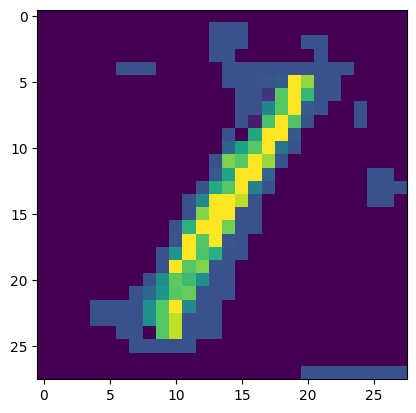

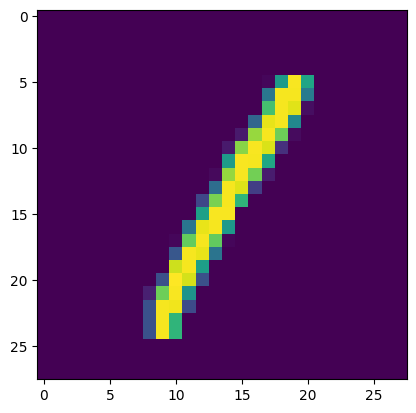

In [91]:
plt.imshow(advs[0].reshape(28,28))
plt.show()
plt.imshow(xx[0].reshape(28,28))
plt.show()

In [197]:
model.layer0.epsilon = 15.0
model.layer1.epsilon = 20.

### Analyze

In [204]:
fmodel = fb.PyTorchModel(model.eval(), bounds=(-1, 1), device=device)
attack = fa.FGSM()

In [205]:
for i, (xx, yy) in enumerate(tqdm(test_loader)):
    xx = xx.reshape(-1, 28*28)
    
    with torch.no_grad():
        yout = model(xx, calculate_epsilon=True)
    reject0 = model.layer0.temp_activ
    reject1 = model.layer1.temp_activ
    
    _, advs, success = attack(fmodel, xx, yy, epsilons=0.5)
    with torch.no_grad(): ### just to access neuron activation for adverserial examples
        yout = model(advs, calculate_epsilon=True)
    _reject0 = model.layer0.temp_activ
    _reject1 = model.layer1.temp_activ
    break

  0%|                                                             | 0/200 [00:00<?, ?it/s]


In [206]:
reject0.max(dim=1)[1]

tensor([ 21, 130,  12, 130,  59,  12,  94, 130, 130,  40,   1, 130,   7,  26,
         33, 108,  14, 101, 130,  39, 117,  27, 130,  72,  39,  44,   0,  51,
        130,  93,  76,  54,   8, 130,  47, 130, 100,  54, 118,  85,  80,  47,
         14,  12,  54, 116,  70,  39,  51,  81])

In [207]:
_reject0.max(dim=1)[1]

tensor([ 21,  17,  80,   6,  59,  56, 130, 130, 130, 129,  57,  22,  94, 130,
         85, 108,  14, 130, 130,  39, 117,  66, 130,  71,  91, 130,  39,  94,
        130,  93,  76,  54,  17, 130, 130, 130,  21,  33, 118,  79,  80, 130,
        102, 130, 130,  42, 130,  39, 130,  14])

In [208]:
reject0[:,-1]

tensor([8.8448e-03, 7.4307e-01, 4.7572e-04, 4.0520e-01, 2.4440e-02, 1.0498e-03,
        1.1349e-01, 1.7271e-01, 9.3908e-01, 2.4719e-02, 1.4344e-02, 5.0568e-01,
        5.6638e-03, 6.0501e-02, 5.3775e-04, 9.8483e-02, 1.9524e-02, 8.3758e-02,
        7.3836e-01, 3.3046e-03, 1.4253e-02, 6.9561e-03, 4.3269e-01, 4.0628e-02,
        4.9133e-03, 6.6441e-02, 1.1398e-02, 9.7606e-03, 4.0948e-01, 7.8524e-04,
        1.2003e-01, 2.8765e-04, 4.1776e-02, 9.2561e-01, 4.5377e-02, 9.6609e-01,
        1.8023e-02, 4.6355e-04, 5.4945e-02, 9.4185e-04, 8.0242e-04, 1.1425e-02,
        1.6065e-02, 6.0196e-02, 2.4395e-02, 3.0491e-02, 7.7579e-03, 5.5520e-02,
        7.1278e-02, 5.6799e-02])

In [209]:
_reject0[:,-1]

tensor([2.0007e-02, 2.1700e-01, 1.7247e-03, 1.1148e-01, 4.8448e-02, 1.5924e-02,
        5.6532e-01, 7.1196e-01, 9.8420e-01, 1.2974e-01, 1.1823e-02, 3.3166e-02,
        1.4354e-01, 5.5179e-01, 8.0516e-04, 9.1183e-03, 2.1296e-01, 5.7920e-01,
        9.7325e-01, 6.9618e-03, 2.7986e-02, 9.0466e-03, 6.5318e-01, 4.2458e-02,
        9.1681e-03, 6.5924e-01, 1.6065e-02, 1.7106e-01, 9.5670e-01, 1.0005e-02,
        4.4473e-01, 9.8424e-04, 2.2908e-02, 9.3337e-01, 6.3539e-01, 9.8197e-01,
        2.4151e-02, 7.0343e-04, 7.4070e-02, 1.6468e-03, 3.2367e-03, 1.1337e-01,
        1.6770e-01, 4.7839e-01, 2.8704e-01, 2.0560e-02, 2.1522e-01, 9.0274e-02,
        7.8886e-01, 8.0312e-02])